In [1]:
import sys
import os
import pathlib
import json
import pyvista as pv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


working_dir = pathlib.Path(os.path.abspath(""))
sys.path.append(str(working_dir.parent))
from util import find_runs  # noqa: E402

In [2]:
location_error = pd.DataFrame()
velocity_error = pd.DataFrame()
velocity_error_relative = pd.DataFrame()

# Iterate over all runs
for run_path in find_runs(working_dir):
    # Read parameters.json
    with open(run_path / "parameters.json") as file:
        parameters = json.load(file)

    # Calculate mean L2 error norm for each timestep
    location_error_data = []
    velocity_error_data = []
    velocity_error_relative_data = []
    indices = []
    for timestep_path in (run_path / "solution").glob("*_particles_*.pvtu"):
        # Use the timestep number from the filename as index
        timestep = int(timestep_path.stem.split("_")[-1])
        if timestep == 999999:
            continue
        indices.append(timestep)
        
        mesh = pv.read(timestep_path)

        # Calculate error norm for each particle
        mesh["location_error"] = np.linalg.norm(
            mesh.points - mesh["analytical_location"], axis=1
        )

        # For the velocity, we calculate the relative error
        mesh["velocity_error"] = np.linalg.norm(
            mesh["velocity"] - mesh["analytical_velocity"], axis=1
        )
        mesh["velocity_error_relative"] = mesh["velocity_error"] / np.linalg.norm(
            mesh["analytical_velocity"], axis=1
        )

        # Calculate median error norm over all particles
        location_error_data.append(mesh["location_error"].mean())
        velocity_error_data.append(mesh["velocity_error"].mean())
        velocity_error_relative_data.append(np.median(mesh["velocity_error_relative"]))


    # Generate descriptive column name
    column_name = {
        "nearest-neighbor": "NN",
        "rbf-pum-direct": "RBF",
    }[parameters["mapping"]]

    if parameters["mapping"] == "rbf-pum-direct":
        column_name += (
            "_"
            + {
                "compact-polynomial-c0": "CP0",
                "compact-polynomial-c2": "CP2",
                "compact-polynomial-c4": "CP4",
                "compact-polynomial-c6": "CP6",
                "compact-polynomial-c8": "CP8",
            }[parameters["basis_function"]]
        )

        column_name += f"_{parameters['support_radius']}"

    column_name += f"_{parameters['refinement']}"

    # Insert into DataFrame
    location_error[column_name] = pd.Series(data=location_error_data, index=indices)
    velocity_error[column_name] = pd.Series(data=velocity_error_data, index=indices)
    velocity_error_relative[column_name] = pd.Series(
        data=velocity_error_relative_data, index=indices
    )

/tmp/ipykernel_125454/882075278.py:34: RuntimeWarning: invalid value encountered in divide
  mesh["velocity_error_relative"] = mesh["velocity_error"] / np.linalg.norm(
/tmp/ipykernel_125454/882075278.py:34: RuntimeWarning: invalid value encountered in divide
  mesh["velocity_error_relative"] = mesh["velocity_error"] / np.linalg.norm(
/tmp/ipykernel_125454/882075278.py:34: RuntimeWarning: invalid value encountered in divide
  mesh["velocity_error_relative"] = mesh["velocity_error"] / np.linalg.norm(
/tmp/ipykernel_125454/882075278.py:34: RuntimeWarning: invalid value encountered in divide
  mesh["velocity_error_relative"] = mesh["velocity_error"] / np.linalg.norm(
/tmp/ipykernel_125454/882075278.py:34: RuntimeWarning: invalid value encountered in divide
  mesh["velocity_error_relative"] = mesh["velocity_error"] / np.linalg.norm(
/tmp/ipykernel_125454/882075278.py:34: RuntimeWarning: invalid value encountered in divide
  mesh["velocity_error_relative"] = mesh["velocity_error"] / np.linal

In [3]:
# Sort columns by name
location_error.sort_index(inplace=True, axis=1)
velocity_error.sort_index(inplace=True, axis=1)
velocity_error_relative.sort_index(inplace=True, axis=1)

# Sort rows by timestep number
location_error.sort_index(inplace=True, axis=0)
velocity_error.sort_index(inplace=True, axis=0)
velocity_error_relative.sort_index(inplace=True, axis=0)

In [4]:
velocity_error.filter(like="NN", axis=1).describe()

,NN_2,NN_3,NN_4,NN_5,NN_6
count,102.000000,102.000000,102.000000,102.000000,102.000000
mean,0.166871,0.088728,0.043740,0.021952,0.010925
std,0.086523,0.043819,0.022029,0.011070,0.005540
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.098417,0.055448,0.025165,0.012929,0.006436
50%,0.175984,0.094937,0.046334,0.023942,0.011713
75%,0.234080,0.130758,0.065305,0.032875,0.016173
max,0.300585,0.148620,0.071695,0.036071,0.018540


In [5]:
velocity_error.filter(like="RBF_CP4", axis=1).describe()

,RBF_CP4_0.5_2,RBF_CP4_0.5_3,RBF_CP4_0.5_4,RBF_CP4_0.5_5,RBF_CP4_0.5_6
count,102.000000,102.000000,102.000000,102.000000,102.000000
mean,0.071131,0.006969,0.000394,0.000058,0.000007
std,0.038233,0.003309,0.000202,0.000028,0.000003
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.045040,0.004644,0.000229,0.000038,0.000004
50%,0.062596,0.007489,0.000437,0.000063,0.000007
75%,0.104633,0.009877,0.000568,0.000084,0.000009
max,0.131262,0.011528,0.000694,0.000103,0.000012


array([<Axes: xlabel='timestep'>, <Axes: xlabel='timestep'>,
       <Axes: xlabel='timestep'>], dtype=object)

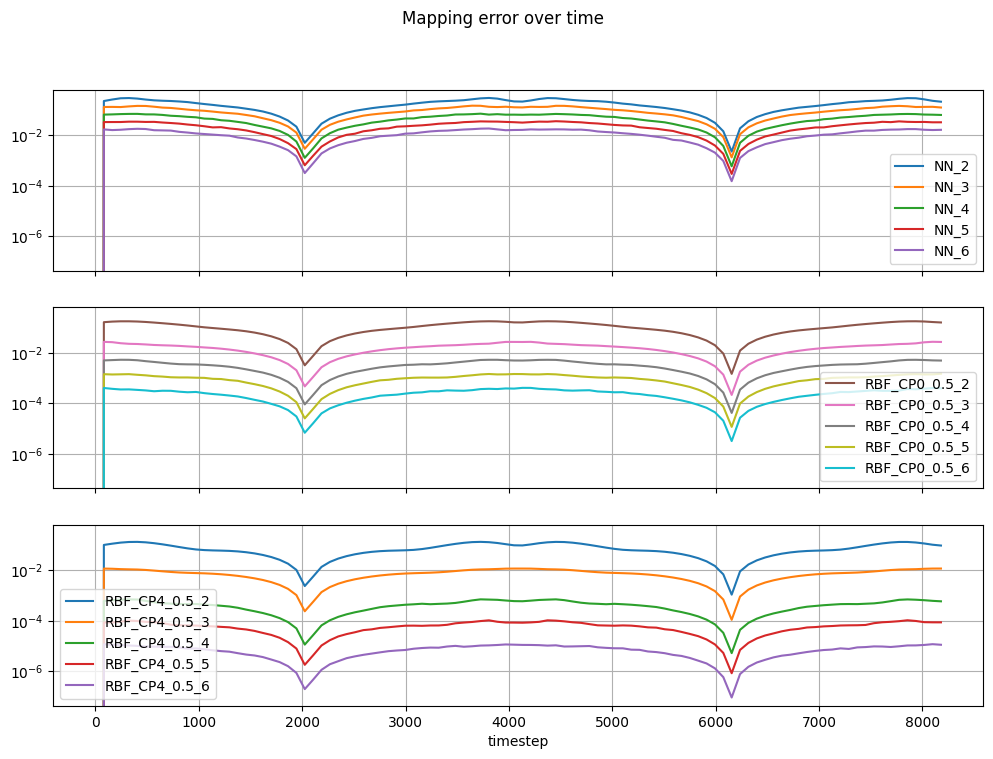

In [6]:
velocity_error.filter(
    axis=1,
    items=[
        "NN_2",
        "NN_3",
        "NN_4",
        "NN_5",
        "NN_6",
        "NN_7",
        "RBF_CP0_0.5_2",
        "RBF_CP0_0.5_3",
        "RBF_CP0_0.5_4",
        "RBF_CP0_0.5_5",
        "RBF_CP0_0.5_6",
        "RBF_CP0_0.5_7",
        "RBF_CP4_0.5_2",
        "RBF_CP4_0.5_3",
        "RBF_CP4_0.5_4",
        "RBF_CP4_0.5_5",
        "RBF_CP4_0.5_6",
        "RBF_CP4_0.5_7",
    ],
).plot(
    title="Mapping error over time",
    figsize=(12, 8),
    grid=True,
    xlabel="timestep",
    logy=True,
    sharey=True,
    subplots=[
        (
            "NN_2",
            "NN_3",
            "NN_4",
            "NN_5",
            "NN_6",
        ),
        (
            "RBF_CP0_0.5_2",
            "RBF_CP0_0.5_3",
            "RBF_CP0_0.5_4",
            "RBF_CP0_0.5_5",
            "RBF_CP0_0.5_6",
        ),
        (
            "RBF_CP4_0.5_2",
            "RBF_CP4_0.5_3",
            "RBF_CP4_0.5_4",
            "RBF_CP4_0.5_5",
            "RBF_CP4_0.5_6",
        ),
    ],
)